In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
class LSTMGenerator(nn.Module):
    """Generator with LSTM"""
    def __init__(self, latent_dim, ts_dim, hidden_dim=256, num_layers=1):
        super(LSTMGenerator, self).__init__()

        self.ts_dim = ts_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(num_layers*hidden_dim, num_layers*ts_dim)

    def forward(self, x):
        x = x.reshape(x.shape[0], self.num_layers, x.shape[1])
        out, _ = self.lstm(x)
        out = self.linear(out.reshape(x.size(0), x.size(1)*self.hidden_dim))
        out = out.view(x.size(0), self.ts_dim, self.num_layers)
        return out

In [3]:
noise_len = 32
n_samples = 100
n_groups = 5

In [ ]:
models_directory = 'models/'
Fakedata_directory = 'Fakedata/'

In [4]:
generator_groupgan = {}

for i in range(n_groups):
    generator_groupgan[i] = LSTMGenerator(noise_len, n_samples)

In [5]:
for i in range(n_groups):
    # LSTM MLP
    
    # With CD 0
    generator_groupgan_temp_dict = torch.load(f'{models_directory}/Generator_{i}.pt', map_location=torch.device('cpu'))
    new_generator_groupgan_temp_dict = deepcopy(generator_groupgan_temp_dict)
    for key in generator_groupgan_temp_dict.keys():
        new_generator_groupgan_temp_dict[key[7:]] = new_generator_groupgan_temp_dict.pop(key)
    generator_groupgan[i].load_state_dict(new_generator_groupgan_temp_dict)

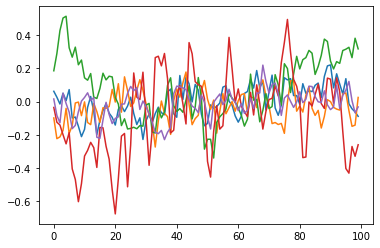

In [6]:
new_noise = torch.randn((1024, noise_len)).float()

generated_samples_groupgan = {}

for i in range(n_groups):
    generated_samples_groupgan[i] = generator_groupgan[i](new_noise).detach().cpu().numpy()
    
plt.figure()
plt.plot(generated_samples_groupgan[0][0, :], label='Channel 1')
plt.plot(generated_samples_groupgan[1][0, :], label='Channel 2')
plt.plot(generated_samples_groupgan[2][0, :], label='Channel 3')
plt.plot(generated_samples_groupgan[3][0, :], label='Channel 4')
plt.plot(generated_samples_groupgan[4][0, :], label='Channel 5')
plt.show()

In [7]:
# create dataframe of generated samples
generated_samples_groupgan_df = {}

for i in range(n_groups):
    generated_samples_groupgan_df[i] = pd.DataFrame(generated_samples_groupgan[i].squeeze())

In [8]:
# save generated samples to csv

pd.concat([generated for generated in generated_samples_groupgan_df.values()], axis=1, ignore_index=True).to_csv(f'Fake_Data/generated_samples_groupgan.csv', index=False)

In [5]:
import pandas as pd
import numpy as np

In [8]:
data = np.array(pd.read_csv('Fake_Data/generated_samples_groupgan.csv'))

data = data.reshape(data.shape[0], -1, 5)

In [10]:
np.save('Fake_Data/eeg_generated_samples_groupgan.npy', data)